In [11]:
# Your code here . . .
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/CRMLSSold202505_filled.csv')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
df = pd.read_csv('/content/drive/MyDrive/CRMLSSold202505_filled.csv')
print(f"Original data: {df.shape}")

# Step 1: Filter for single family homes only
df = df[(df['PropertyType'] == 'Residential') &
        (df['PropertySubType'] == 'SingleFamilyResidence')]
print(f"After filtering: {df.shape}")

# Step 2: Keep only the columns we need
keep_columns = [
    'ClosePrice',           # What we're predicting
    'BedroomsTotal',        # Beds
    'BathroomsTotalInteger', # Baths
    'LivingArea',           # Square feet
    'LotSizeSquareFeet',    # Lot size
    'YearBuilt',            # Year built
    'PoolPrivateYN',        # Pool
    'GarageSpaces',         # Garage
    'ViewYN',               # View
    'PostalCode',           # Zip code
    'City',                 # City
    'CountyOrParish',       # County
    'Latitude',             # Location
    'Longitude',            # Location
    'ListPrice',            # Keep for neighborhood analysis
    'OriginalListPrice'     # Keep for neighborhood analysis
]

# Only keep columns that actually exist in your data
final_columns = [col for col in keep_columns if col in df.columns]
df = df[final_columns]
print(f"After selecting columns: {df.shape}")
print(f"Final columns: {final_columns}")

# Step 3: Clean the data
# Remove rows with missing ClosePrice
df = df.dropna(subset=['ClosePrice'])
print(f"After removing missing ClosePrice: {df.shape}")

# Fill missing values with simple rules
# Numbers: fill with median
numeric_cols = ['BedroomsTotal', 'BathroomsTotalInteger', 'LivingArea',
                'LotSizeSquareFeet', 'YearBuilt', 'GarageSpaces']
for col in numeric_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

# Y/N columns: fill with 'N'
yn_cols = ['PoolPrivateYN', 'ViewYN']
for col in yn_cols:
    if col in df.columns:
        df[col] = df[col].fillna('N')

# Location: fill with most common
location_cols = ['City', 'CountyOrParish', 'PostalCode']
for col in location_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'Unknown')

print(f"Missing values after cleaning:")
print(df.isnull().sum())

# Step 4: Basic data validation
# Remove unrealistic values
df = df[df['ClosePrice'] > 10000]  # Minimum $10k
df = df[df['ClosePrice'] < 10000000]  # Maximum $10M
if 'LivingArea' in df.columns:
    df = df[df['LivingArea'] > 200]  # Minimum 200 sq ft
    df = df[df['LivingArea'] < 10000]  # Maximum 10,000 sq ft

print(f"Final cleaned data: {df.shape}")

# Step 5: Save cleaned data
df.to_csv('/content/drive/MyDrive/cleaned_dataset05_zara.csv', index=False)
print("✅ Cleaned data saved as 'cleaned_dataset05_zara.csv'")

# Quick summary
print(f"\n📊 Summary:")
print(f"ClosePrice range: ${df['ClosePrice'].min():,.0f} to ${df['ClosePrice'].max():,.0f}")
print(f"Average price: ${df['ClosePrice'].mean():,.0f}")
if 'LivingArea' in df.columns:
    print(f"Living area range: {df['LivingArea'].min():.0f} to {df['LivingArea'].max():.0f} sq ft")

Original data: (23154, 80)
After filtering: (11777, 80)
After selecting columns: (11777, 16)
Final columns: ['ClosePrice', 'BedroomsTotal', 'BathroomsTotalInteger', 'LivingArea', 'LotSizeSquareFeet', 'YearBuilt', 'PoolPrivateYN', 'GarageSpaces', 'ViewYN', 'PostalCode', 'City', 'CountyOrParish', 'Latitude', 'Longitude', 'ListPrice', 'OriginalListPrice']
After removing missing ClosePrice: (11777, 16)
Missing values after cleaning:
ClosePrice                0
BedroomsTotal             0
BathroomsTotalInteger     0
LivingArea                0
LotSizeSquareFeet         0
YearBuilt                 0
PoolPrivateYN             0
GarageSpaces              0
ViewYN                    0
PostalCode                0
City                      0
CountyOrParish            0
Latitude                  0
Longitude                 0
ListPrice                 0
OriginalListPrice        19
dtype: int64
Final cleaned data: (11713, 16)
✅ Cleaned data saved as 'cleaned_dataset05_zara.csv'

📊 Summary:
ClosePric


Simple Linear Regression Model
Predicting ClosePrice using: LivingArea

Model Equation:
ClosePrice = 1,184,177.30 + 497,355.44 × LivingArea

Training Metrics:
  RMSE: $695,671.07
  R²: 0.3382
  MAE: $493,084.19
  MAPE: 51.76%
  Median MAPE: 35.43%

Testing Metrics:
  RMSE: $697,492.91
  R²: 0.3601
  MAE: $488,176.11
  MAPE: 50.68%
  Median MAPE: 34.01%


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


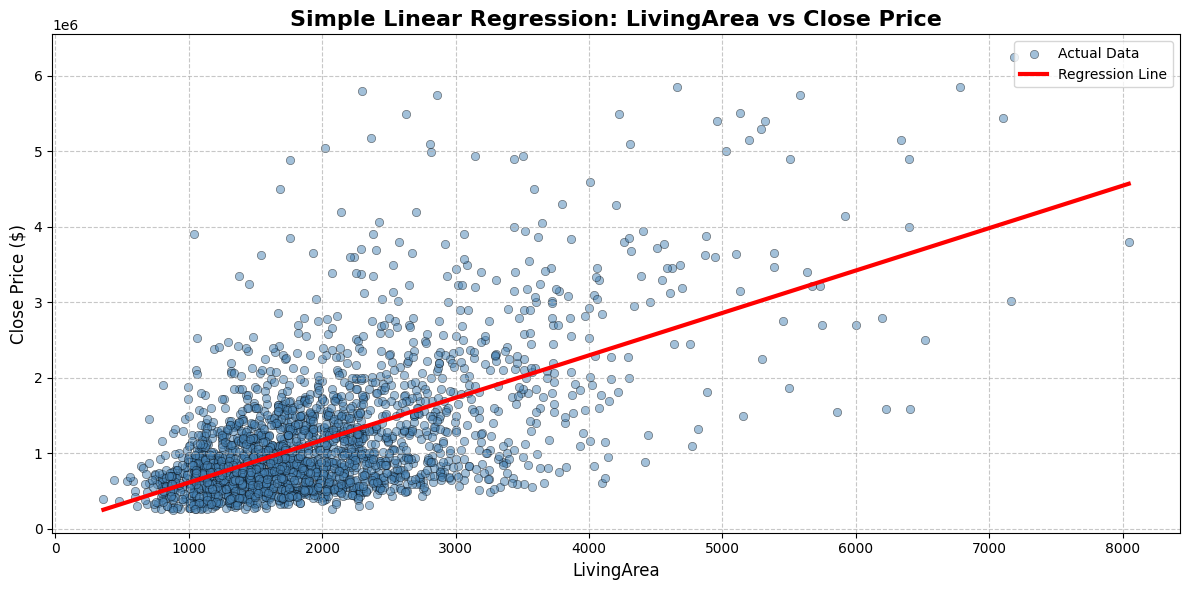

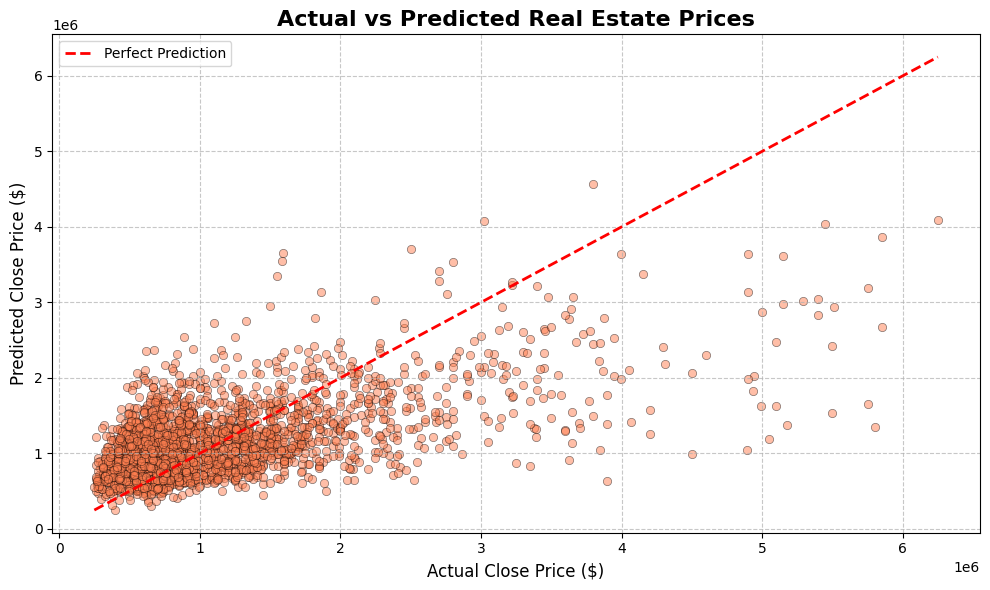

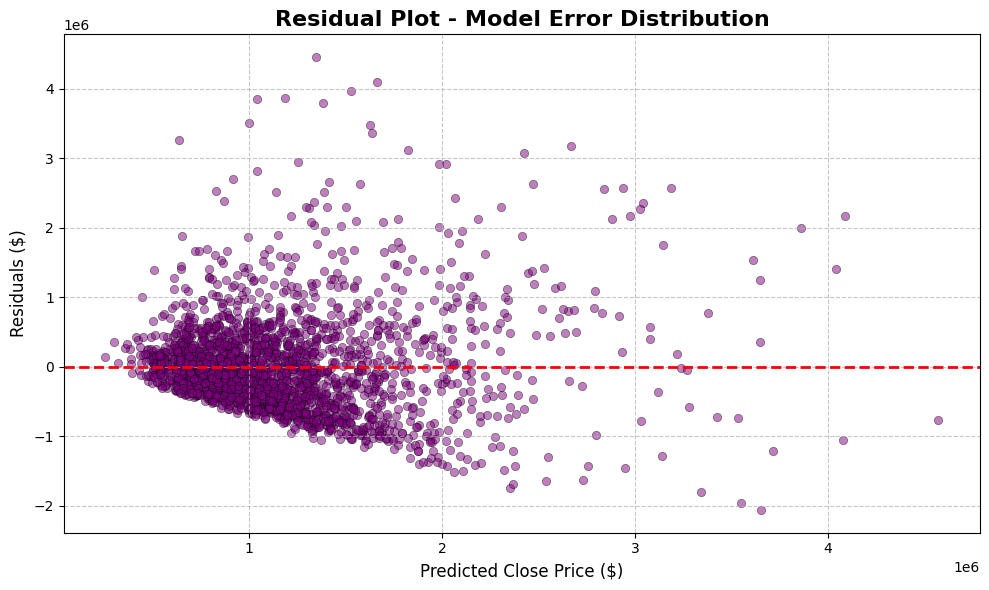

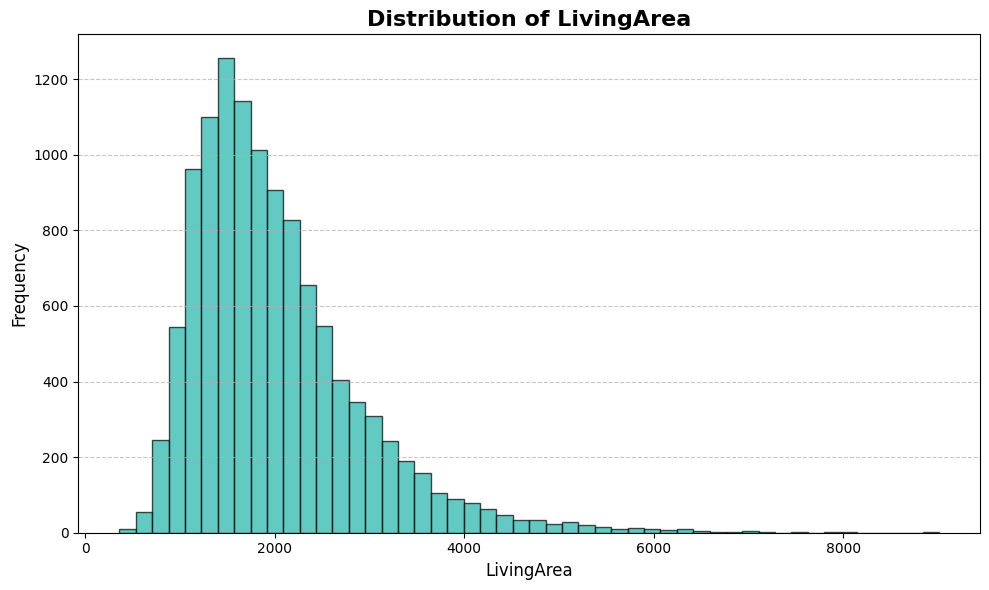

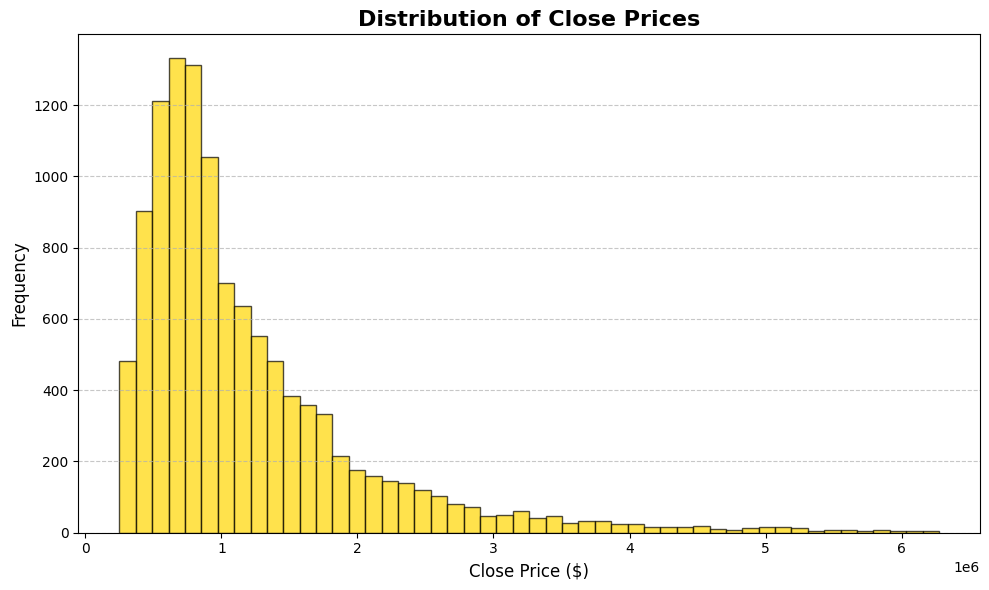


Simple Linear Regression complete!
Predictions saved to 'simple_linear_regression_LivingArea_predictions.csv'


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

# Load the cleaned dataset
df = pd.read_csv('/content/drive/MyDrive/cleaned_CRMLSSold202505_zara.csv')

# Creating some useful features before we start modeling
df['CloseDate'] = pd.to_datetime(df['CloseDate'])
df['close_month'] = df['CloseDate'].dt.month
df['close_year'] = df['CloseDate'].dt.year
df['property_age'] = 2025 - df['YearBuilt']

# This is how we can indirectly use list price info without causing data leakage
# We're looking at what similar homes in the same zip code typically sell for per sqft
df['zipcode_median_price_per_sqft'] = df.groupby('PostalCode')['ClosePrice'].transform('median') / df.groupby('PostalCode')['LivingArea'].transform('median')

# Picking living area for linear regression
feature_name = 'LivingArea'

print("\nSimple Linear Regression Model")
print("Predicting ClosePrice using:", feature_name)
print("="*60)

# Set up our X (feature) and y (target)
X = df[[feature_name]].copy()
y = df['ClosePrice'].copy()


X = X.fillna(X.median())
y = y.fillna(y.median())
X = X.dropna()
y = y[X.index]

# split into training / testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# training the model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

print("\nModel Equation:")
print(f"ClosePrice = {model.intercept_:,.2f} + {model.coef_[0]:,.2f} × {feature_name}")

#metrics
def evaluate_model(y_true, y_pred, label):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    median_mape = np.median(np.abs((y_true - y_pred) / y_true)) * 100

    print(f"\n{label} Metrics:")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  R²: {r2:.4f}")
    print(f"  MAE: ${mae:,.2f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  Median MAPE: {median_mape:.2f}%")

    return rmse, r2, mae, mape, median_mape

# Get predictions for both training and testing data
y_pred_train = model.predict(X_train_scaled)
y_pred_test = model.predict(X_test_scaled)

train_rmse, train_r2, train_mae, train_mape, train_med_mape = evaluate_model(y_train, y_pred_train, "Training")
test_rmse, test_r2, test_mae, test_mape, test_med_mape = evaluate_model(y_test, y_pred_test, "Testing")

# scatter plot w regression line
plt.figure(figsize=(12, 6))
plt.scatter(X_test, y_test, alpha=0.5, color='steelblue', edgecolors='black', linewidth=0.5, label='Actual Data')

X_range = np.linspace(X_test.min(), X_test.max(), 100).reshape(-1, 1)
X_range_scaled = scaler.transform(X_range)
y_pred_line = model.predict(X_range_scaled)
plt.plot(X_range, y_pred_line, 'r-', linewidth=3, label='Regression Line')

plt.xlabel(f'{feature_name}', fontsize=12)
plt.ylabel('Close Price ($)', fontsize=12)
plt.title(f'Simple Linear Regression: {feature_name} vs Close Price', fontsize=16, fontweight='bold')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, alpha=0.5, color='coral', edgecolors='black', linewidth=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=2, label='Perfect Prediction')
plt.xlabel('Actual Close Price ($)', fontsize=12)
plt.ylabel('Predicted Close Price ($)', fontsize=12)
plt.title('Actual vs Predicted Real Estate Prices', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

# residuals
residuals = y_test - y_pred_test
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_test, residuals, alpha=0.5, color='purple', edgecolors='black', linewidth=0.5)
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Close Price ($)', fontsize=12)
plt.ylabel('Residuals ($)', fontsize=12)
plt.title('Residual Plot - Model Error Distribution', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# feature distribution
plt.figure(figsize=(10, 6))
plt.hist(df[feature_name].dropna(), bins=50, color='lightseagreen', edgecolor='black', alpha=0.7)
plt.xlabel(f'{feature_name}', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title(f'Distribution of {feature_name}', fontsize=16, fontweight='bold')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# price distribution
plt.figure(figsize=(10, 6))
plt.hist(y, bins=50, color='gold', edgecolor='black', alpha=0.7)
plt.xlabel('Close Price ($)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Close Prices', fontsize=16, fontweight='bold')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Save predictions
results_df = pd.DataFrame({
    feature_name: X_test.values.flatten(),
    'Actual_Price': y_test.values,
    'Predicted_Price': y_pred_test,
    'Residual': residuals
})
results_df.to_csv(f'simple_linear_regression_{feature_name}_predictions.csv', index=False)

print("\nSimple Linear Regression complete!")
print(f"Predictions saved to 'simple_linear_regression_{feature_name}_predictions.csv'")